<a href="https://colab.research.google.com/github/Benjamiiin/Etnicity-Coctail/blob/main/NLPProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing required files

In [ ]:
# @title Imports {"display-mode":"form"}
!pip install chronos-forecasting
# Clone the repository

!git clone https://github.com/amazon-science/chronos-forecasting.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Selected optimal context length: 96
Forecast Default Shape: (1280,)
Forecast Adaptive Shape: (1280,)
Fixed Forecast Default Shape: (64,)
Fixed Forecast Adaptive Shape: (64,)
Actual Values Shape: (64,)

 **Forecast Accuracy Comparison**
 Default Forecast  → MAE: 68.18, RMSE: 72.78
 Adaptive Forecast → MAE: 65.66, RMSE: 69.60

 Improvement with Adaptive Context Length:
   MAE Improvement: 2.53
   RMSE Improvement: 3.17

 **Forecast Accuracy Comparison (Including Uncertainty)**
 Default Forecast  → MAE: 68.18, RMSE: 72.78, Coverage: 54.69%
 Adaptive Forecast → MAE: 65.66, RMSE: 69.60, Coverage: 20.31%


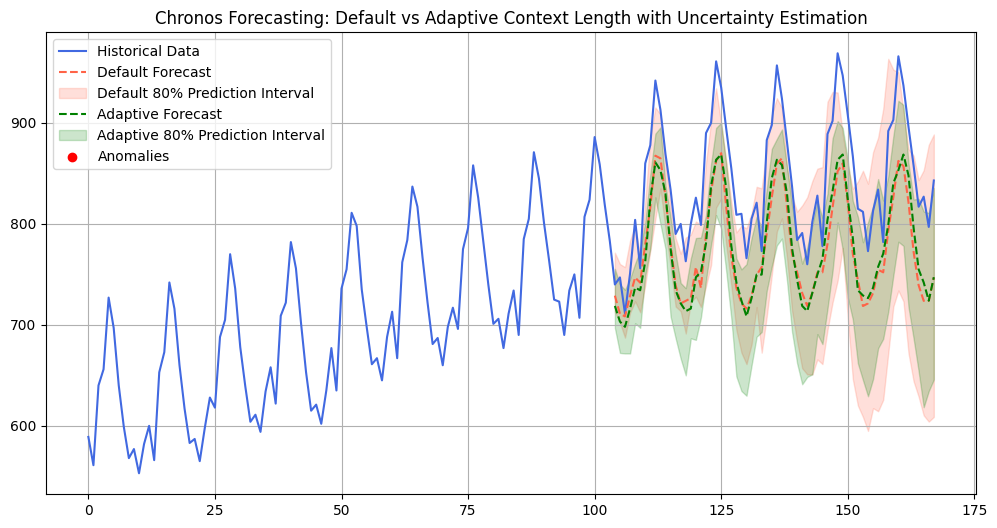

Total number of points are : 64
Number of anomalies detected std: 0, %0.0
Number of anomalies detected ci: 9, %14.0625


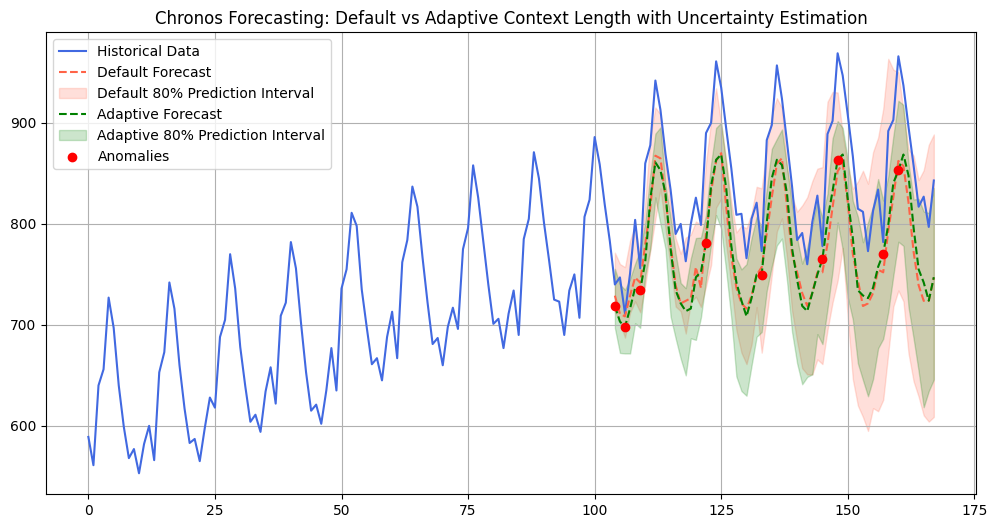

In [ ]:
# @title chronos-t5-tiny {"vertical-output":true,"display-mode":"form"}
import pandas as pd
import torch
from chronos import BaseChronosPipeline, ChronosPipeline, ChronosBoltPipeline
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import acf, pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy import stats

#  Define Forecast Horizon
PREDICTION_HORIZON = 64

# #  Feature 1: Dynamically determines the best context length based on autocorrelation
def find_optimal_context_length(time_series, max_lag=48):
    acf_values = acf(time_series, nlags=max_lag)
    seasonality = np.argmax(acf_values > 0.5)  # Find highest correlation lag
    if seasonality == 0:
        seasonality = max_lag  # Default to max lag if no seasonality is found
    optimal_length = min(len(time_series), seasonality * 2)  # Use 2 full cycles
    print(f"Selected optimal context length: {optimal_length}")
    return optimal_length



def find_optimal_context_length_pacf(time_series, max_lag=48):
    # Calculate Partial Autocorrelation values
    pacf_values = pacf(time_series, nlags=max_lag)

    # Print the first 10 PACF values for analysis
    print("First 10 PACF Values:", pacf_values[:10])

    # Set a threshold for significant correlation
    threshold = 0.2  # This can be adjusted based on your data

    # Find the lag with the highest PACF value above the threshold (excluding lag 0)
    significant_lags = np.where(np.abs(pacf_values) > threshold)[0]

    if len(significant_lags) == 0:
        # Fallback to max lag if no significant lag is found
        optimal_length = max_lag
    else:
        # Use the highest significant lag to define context length
        optimal_length = min(len(time_series), significant_lags[-1] * 2)

    print(f"Selected optimal context length using PACF: {optimal_length}")
    return optimal_length



#  Load the Chronos model
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-tiny",  # Use "amazon/chronos-bolt-small" for Bolt model
    device_map="cuda",  # Change to "cuda" if using GPU
    torch_dtype=torch.bfloat16,
)

df = pd.read_csv(
    "https://raw.githubusercontent.com/plotly/datasets/refs/heads/master/monthly-milk-production-pounds.csv",
    parse_dates=["Month"]
)
df.rename(columns={"Monthly milk production (pounds per cow)": "Production"}, inplace=True)
df = df.sort_values("Month")

# 🔹 Define Training Data & Actual Future Values
train_data = df["Production"].values[:-PREDICTION_HORIZON]  # Use everything except last 24 months
actual_values = df["Production"].values[-PREDICTION_HORIZON:]  # Keep last 24 months for comparison




# --------------------------------------------------------------------------------------------
#  Default Forecast (Fixed Context Length - Uses Entire History)
# --------------------------------------------------------------------------------------------
context_default = torch.tensor(train_data, dtype=torch.float32)
quantiles_default, mean_default = pipeline.predict_quantiles(
    context=context_default,
    prediction_length=PREDICTION_HORIZON,
    quantile_levels=[0.1, 0.5, 0.9],  # 10th (low), 50th (median), 90th (high)
)
forecast_default = pipeline.predict(context=context_default, prediction_length=PREDICTION_HORIZON)
forecast_default_np = forecast_default.numpy().flatten()  # Convert tensor to NumPy for analysis

# --------------------------------------------------------------------------------------------
#  Adaptive Forecast (Uses Feature 1 to Determine Best Context Length)
# --------------------------------------------------------------------------------------------
context_length = find_optimal_context_length(train_data)  # Compute optimal length
context_adaptive = torch.tensor(train_data[-context_length:], dtype=torch.float32)
quantiles_adaptive, mean_adaptive = pipeline.predict_quantiles(
    context=context_adaptive,
    prediction_length=PREDICTION_HORIZON,
    quantile_levels=[0.1, 0.5, 0.9],
)
forecast_adaptive = pipeline.predict(context=context_adaptive, prediction_length=PREDICTION_HORIZON)
forecast_adaptive_np = forecast_adaptive.numpy().flatten()  # Convert tensor to NumPy for analysis





print(f"Forecast Default Shape: {forecast_default_np.shape}")  # Debugging
print(f"Forecast Adaptive Shape: {forecast_adaptive_np.shape}")  # Debugging
# Fix forecast shape if it is incorrectly flattened
if len(forecast_default_np.shape) == 1:
    forecast_default_np = forecast_default_np.reshape(-1, PREDICTION_HORIZON)
if len(forecast_adaptive_np.shape) == 1:
    forecast_adaptive_np = forecast_adaptive_np.reshape(-1, PREDICTION_HORIZON)

# Take the median across samples (axis=0)
forecast_default_np = np.median(forecast_default_np, axis=0)
forecast_adaptive_np = np.median(forecast_adaptive_np, axis=0)

# Double-check that forecast now matches actual values
print(f"Fixed Forecast Default Shape: {forecast_default_np.shape}")  # Should be (24,)
print(f"Fixed Forecast Adaptive Shape: {forecast_adaptive_np.shape}")  # Should be (24,)
print(f"Actual Values Shape: {actual_values.shape}")  # Should be (24,)

# --------------------------------------------------------------------------------------------
#  Compare Forecast Accuracy using MAE & RMSE
# --------------------------------------------------------------------------------------------
mae_default = mean_absolute_error(actual_values, forecast_default_np)
rmse_default = np.sqrt(mean_squared_error(actual_values, forecast_default_np))

mae_adaptive = mean_absolute_error(actual_values, forecast_adaptive_np)
rmse_adaptive = np.sqrt(mean_squared_error(actual_values, forecast_adaptive_np))

print("\n **Forecast Accuracy Comparison**")
print(f" Default Forecast  → MAE: {mae_default:.2f}, RMSE: {rmse_default:.2f}")
print(f" Adaptive Forecast → MAE: {mae_adaptive:.2f}, RMSE: {rmse_adaptive:.2f}")

print("\n Improvement with Adaptive Context Length:")
print(f"   MAE Improvement: {mae_default - mae_adaptive:.2f}")
print(f"   RMSE Improvement: {rmse_default - rmse_adaptive:.2f}")


# Extract Prediction Intervals
low_default, median_default, high_default = quantiles_default[0, :, 0], quantiles_default[0, :, 1], quantiles_default[0, :, 2]
low_adaptive, median_adaptive, high_adaptive = quantiles_adaptive[0, :, 0], quantiles_adaptive[0, :, 1], quantiles_adaptive[0, :, 2]
# Ensure all values are NumPy arrays before comparison
low_default_np = low_default.numpy()
high_default_np = high_default.numpy()
low_adaptive_np = low_adaptive.numpy()
high_adaptive_np = high_adaptive.numpy()

# Check how often actual values fall within predicted uncertainty bounds
coverage_default = np.mean((actual_values >= low_default_np) & (actual_values <= high_default_np))
coverage_adaptive = np.mean((actual_values >= low_adaptive_np) & (actual_values <= high_adaptive_np))

print("\n **Forecast Accuracy Comparison (Including Uncertainty)**")
print(f" Default Forecast  → MAE: {mae_default:.2f}, RMSE: {rmse_default:.2f}, Coverage: {coverage_default:.2%}")
print(f" Adaptive Forecast → MAE: {mae_adaptive:.2f}, RMSE: {rmse_adaptive:.2f}, Coverage: {coverage_adaptive:.2%}")

# --------------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------------
# feature2 Detects anomalies where forecast errors exceed 'threshold' standard deviations.

def detect_anomalies(actual, forecast, threshold=2.5):
    """
    Detects anomalies where forecast errors exceed 'threshold' standard deviations.
    """
    errors = np.abs(actual - forecast)
    mean_error = np.mean(errors)
    std_error = np.std(errors)

    anomalies = (errors > mean_error + threshold * std_error)  # Boolean mask
    return anomalies

# Detect anomalies
anomaly_mask = detect_anomalies(actual_values, forecast_adaptive_np)

# --------------------------------------------------------------------------------------------
#  Plot Forecast Comparison
# --------------------------------------------------------------------------------------------
forecast_index = range(len(df) - PREDICTION_HORIZON, len(df))

plt.figure(figsize=(12, 6))
plt.plot(df["Production"], color="royalblue", label="Historical Data")

# Default Forecast
plt.plot(forecast_index, forecast_default_np, color="tomato", linestyle="dashed", label="Default Forecast")
plt.fill_between(forecast_index, low_default, high_default, color="tomato", alpha=0.2, label="Default 80% Prediction Interval")

# Adaptive Forecast
plt.plot(forecast_index, forecast_adaptive_np, color="green", linestyle="dashed", label="Adaptive Forecast")
plt.fill_between(forecast_index, low_adaptive, high_adaptive, color="green", alpha=0.2, label="Adaptive 80% Prediction Interval")

plt.scatter(
    np.array(forecast_index)[anomaly_mask],
    forecast_adaptive_np[anomaly_mask],
    color="red",
    label="Anomalies",
    zorder=3
)
plt.legend()
plt.grid()
plt.title("Chronos Forecasting: Default vs Adaptive Context Length with Uncertainty Estimation")
plt.show()

confidence = 0.85

def detect_anomalies_ci(actual, forecast, confidence=confidence):
    errors = np.abs(actual - forecast)
    mean_error = np.mean(errors)
    std_error = np.std(errors)  # Use standard deviation directly

    margin = stats.t.ppf((1 + confidence) / 2.0, df=len(errors) - 1) * std_error  # Correct margin calculation
    lower_bound = mean_error - margin
    upper_bound = mean_error + margin

    anomalies = (errors < lower_bound) | (errors > upper_bound)
    return anomalies, lower_bound, upper_bound



anomaly_mask_ci, low_ci, high_ci = detect_anomalies_ci(actual_values, forecast_adaptive_np)

total_points = len(forecast_adaptive_np)

print(f"Total number of points are : {total_points}")

num_anomalies = np.sum(anomaly_mask)
print(f"Number of anomalies detected std: {num_anomalies}, %{num_anomalies/total_points}")

num_anomalies = np.sum(anomaly_mask_ci)
print(f"Number of anomalies detected ci: {num_anomalies}, %{(num_anomalies/total_points)*100}")


forecast_index = range(len(df) - PREDICTION_HORIZON, len(df))

plt.figure(figsize=(12, 6))
plt.plot(df["Production"], color="royalblue", label="Historical Data")

# Default Forecast
plt.plot(forecast_index, forecast_default_np, color="tomato", linestyle="dashed", label="Default Forecast")
plt.fill_between(forecast_index, low_default, high_default, color="tomato", alpha=0.2, label="Default 80% Prediction Interval")

# Adaptive Forecast
plt.plot(forecast_index, forecast_adaptive_np, color="green", linestyle="dashed", label="Adaptive Forecast")
plt.fill_between(forecast_index, low_adaptive, high_adaptive, color="green", alpha=0.2, label="Adaptive 80% Prediction Interval")


plt.scatter(
    np.array(forecast_index)[anomaly_mask_ci],
    forecast_adaptive_np[anomaly_mask_ci],
    color="red",
    label="Anomalies",
    zorder=3
)

plt.legend()
plt.grid()
plt.title("Chronos Forecasting: Default vs Adaptive Context Length with Uncertainty Estimation")
plt.show()





#===================================================================================
#===================================================================================
#===================================================================================
#===================================================================================
# forecast = pipeline.predict(context=context, prediction_length=24)
# print("Forecasted Values:\n", forecast.numpy())

# Print available model documentation
# print(ChronosPipeline.predict.__doc__)  # for Chronos models
# print(ChronosBoltPipeline.predict.__doc__)  # for Chronos-Bolt models

# # Plot the forecast
# forecast_index = range(len(df), len(df) + 24)
# low, median, high = quantiles[0, :, 1], quantiles[0, :, 2], quantiles[0, :, 3]

# plt.figure(figsize=(10, 5))
# plt.plot(df["Production"], color="royalblue", label="historical data")
# plt.plot(forecast_index, median, color="tomato", label="median forecast")
# plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="90% prediction interval")
# plt.legend()
# plt.grid()
# plt.show()

# # Extracting encoder embeddings
# embeddings, tokenizer_state = pipeline.embed(context)
# print("Extracted Embeddings:", embeddings.shape)
#===================================================================================




config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/81.8M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

Selected optimal context length: 96
Forecast Default Shape: (1280,)
Forecast Adaptive Shape: (1280,)
Fixed Forecast Default Shape: (64,)
Fixed Forecast Adaptive Shape: (64,)
Actual Values Shape: (64,)

 **Forecast Accuracy Comparison**
 Default Forecast  → MAE: 51.94, RMSE: 56.68
 Adaptive Forecast → MAE: 35.52, RMSE: 38.85

 Improvement with Adaptive Context Length:
   MAE Improvement: 16.42
   RMSE Improvement: 17.83

 **Forecast Accuracy Comparison (Including Uncertainty)**
 Default Forecast  → MAE: 51.94, RMSE: 56.68, Coverage: 56.25%
 Adaptive Forecast → MAE: 35.52, RMSE: 38.85, Coverage: 34.38%


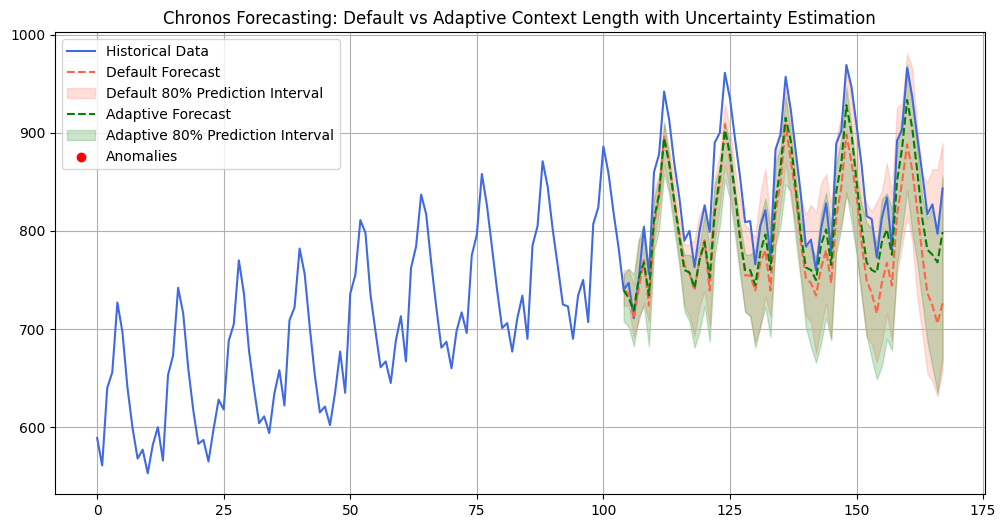

Total number of points are : 64
Number of anomalies detected std: 0, %0.0
Number of anomalies detected ci: 9, %14.0625


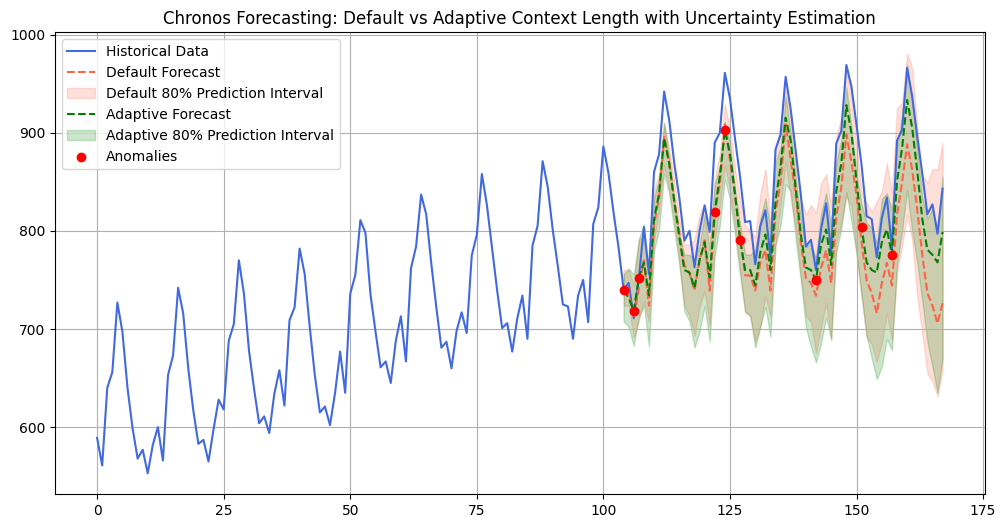

In [ ]:
# @title chronos-t5-mini {"vertical-output":true,"display-mode":"form"}
import pandas as pd
import torch
from chronos import BaseChronosPipeline, ChronosPipeline, ChronosBoltPipeline
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import acf, pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy import stats

#  Define Forecast Horizon
PREDICTION_HORIZON = 64

# #  Feature 1: Dynamically determines the best context length based on autocorrelation
def find_optimal_context_length(time_series, max_lag=48):
    acf_values = acf(time_series, nlags=max_lag)
    seasonality = np.argmax(acf_values > 0.5)  # Find highest correlation lag
    if seasonality == 0:
        seasonality = max_lag  # Default to max lag if no seasonality is found
    optimal_length = min(len(time_series), seasonality * 2)  # Use 2 full cycles
    print(f"Selected optimal context length: {optimal_length}")
    return optimal_length



def find_optimal_context_length_pacf(time_series, max_lag=48):
    # Calculate Partial Autocorrelation values
    pacf_values = pacf(time_series, nlags=max_lag)

    # Print the first 10 PACF values for analysis
    print("First 10 PACF Values:", pacf_values[:10])

    # Set a threshold for significant correlation
    threshold = 0.2  # This can be adjusted based on your data

    # Find the lag with the highest PACF value above the threshold (excluding lag 0)
    significant_lags = np.where(np.abs(pacf_values) > threshold)[0]

    if len(significant_lags) == 0:
        # Fallback to max lag if no significant lag is found
        optimal_length = max_lag
    else:
        # Use the highest significant lag to define context length
        optimal_length = min(len(time_series), significant_lags[-1] * 2)

    print(f"Selected optimal context length using PACF: {optimal_length}")
    return optimal_length



#  Load the Chronos model
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-mini",  # Use "amazon/chronos-bolt-small" for Bolt model
    device_map="cuda",  # Change to "cuda" if using GPU
    torch_dtype=torch.bfloat16,
)

df = pd.read_csv(
    "https://raw.githubusercontent.com/plotly/datasets/refs/heads/master/monthly-milk-production-pounds.csv",
    parse_dates=["Month"]
)
df.rename(columns={"Monthly milk production (pounds per cow)": "Production"}, inplace=True)
df = df.sort_values("Month")

# 🔹 Define Training Data & Actual Future Values
train_data = df["Production"].values[:-PREDICTION_HORIZON]  # Use everything except last 24 months
actual_values = df["Production"].values[-PREDICTION_HORIZON:]  # Keep last 24 months for comparison




# --------------------------------------------------------------------------------------------
#  Default Forecast (Fixed Context Length - Uses Entire History)
# --------------------------------------------------------------------------------------------
context_default = torch.tensor(train_data, dtype=torch.float32)
quantiles_default, mean_default = pipeline.predict_quantiles(
    context=context_default,
    prediction_length=PREDICTION_HORIZON,
    quantile_levels=[0.1, 0.5, 0.9],  # 10th (low), 50th (median), 90th (high)
)
forecast_default = pipeline.predict(context=context_default, prediction_length=PREDICTION_HORIZON)
forecast_default_np = forecast_default.numpy().flatten()  # Convert tensor to NumPy for analysis

# --------------------------------------------------------------------------------------------
#  Adaptive Forecast (Uses Feature 1 to Determine Best Context Length)
# --------------------------------------------------------------------------------------------
context_length = find_optimal_context_length(train_data)  # Compute optimal length
context_adaptive = torch.tensor(train_data[-context_length:], dtype=torch.float32)
quantiles_adaptive, mean_adaptive = pipeline.predict_quantiles(
    context=context_adaptive,
    prediction_length=PREDICTION_HORIZON,
    quantile_levels=[0.1, 0.5, 0.9],
)
forecast_adaptive = pipeline.predict(context=context_adaptive, prediction_length=PREDICTION_HORIZON)
forecast_adaptive_np = forecast_adaptive.numpy().flatten()  # Convert tensor to NumPy for analysis





print(f"Forecast Default Shape: {forecast_default_np.shape}")  # Debugging
print(f"Forecast Adaptive Shape: {forecast_adaptive_np.shape}")  # Debugging
# Fix forecast shape if it is incorrectly flattened
if len(forecast_default_np.shape) == 1:
    forecast_default_np = forecast_default_np.reshape(-1, PREDICTION_HORIZON)
if len(forecast_adaptive_np.shape) == 1:
    forecast_adaptive_np = forecast_adaptive_np.reshape(-1, PREDICTION_HORIZON)

# Take the median across samples (axis=0)
forecast_default_np = np.median(forecast_default_np, axis=0)
forecast_adaptive_np = np.median(forecast_adaptive_np, axis=0)

# Double-check that forecast now matches actual values
print(f"Fixed Forecast Default Shape: {forecast_default_np.shape}")  # Should be (24,)
print(f"Fixed Forecast Adaptive Shape: {forecast_adaptive_np.shape}")  # Should be (24,)
print(f"Actual Values Shape: {actual_values.shape}")  # Should be (24,)

# --------------------------------------------------------------------------------------------
#  Compare Forecast Accuracy using MAE & RMSE
# --------------------------------------------------------------------------------------------
mae_default = mean_absolute_error(actual_values, forecast_default_np)
rmse_default = np.sqrt(mean_squared_error(actual_values, forecast_default_np))

mae_adaptive = mean_absolute_error(actual_values, forecast_adaptive_np)
rmse_adaptive = np.sqrt(mean_squared_error(actual_values, forecast_adaptive_np))

print("\n **Forecast Accuracy Comparison**")
print(f" Default Forecast  → MAE: {mae_default:.2f}, RMSE: {rmse_default:.2f}")
print(f" Adaptive Forecast → MAE: {mae_adaptive:.2f}, RMSE: {rmse_adaptive:.2f}")

print("\n Improvement with Adaptive Context Length:")
print(f"   MAE Improvement: {mae_default - mae_adaptive:.2f}")
print(f"   RMSE Improvement: {rmse_default - rmse_adaptive:.2f}")


# Extract Prediction Intervals
low_default, median_default, high_default = quantiles_default[0, :, 0], quantiles_default[0, :, 1], quantiles_default[0, :, 2]
low_adaptive, median_adaptive, high_adaptive = quantiles_adaptive[0, :, 0], quantiles_adaptive[0, :, 1], quantiles_adaptive[0, :, 2]
# Ensure all values are NumPy arrays before comparison
low_default_np = low_default.numpy()
high_default_np = high_default.numpy()
low_adaptive_np = low_adaptive.numpy()
high_adaptive_np = high_adaptive.numpy()

# Check how often actual values fall within predicted uncertainty bounds
coverage_default = np.mean((actual_values >= low_default_np) & (actual_values <= high_default_np))
coverage_adaptive = np.mean((actual_values >= low_adaptive_np) & (actual_values <= high_adaptive_np))

print("\n **Forecast Accuracy Comparison (Including Uncertainty)**")
print(f" Default Forecast  → MAE: {mae_default:.2f}, RMSE: {rmse_default:.2f}, Coverage: {coverage_default:.2%}")
print(f" Adaptive Forecast → MAE: {mae_adaptive:.2f}, RMSE: {rmse_adaptive:.2f}, Coverage: {coverage_adaptive:.2%}")

# --------------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------------
# feature2 Detects anomalies where forecast errors exceed 'threshold' standard deviations.

def detect_anomalies(actual, forecast, threshold=2.5):
    """
    Detects anomalies where forecast errors exceed 'threshold' standard deviations.
    """
    errors = np.abs(actual - forecast)
    mean_error = np.mean(errors)
    std_error = np.std(errors)

    anomalies = (errors > mean_error + threshold * std_error)  # Boolean mask
    return anomalies

# Detect anomalies
anomaly_mask = detect_anomalies(actual_values, forecast_adaptive_np)

# --------------------------------------------------------------------------------------------
#  Plot Forecast Comparison
# --------------------------------------------------------------------------------------------
forecast_index = range(len(df) - PREDICTION_HORIZON, len(df))

plt.figure(figsize=(12, 6))
plt.plot(df["Production"], color="royalblue", label="Historical Data")

# Default Forecast
plt.plot(forecast_index, forecast_default_np, color="tomato", linestyle="dashed", label="Default Forecast")
plt.fill_between(forecast_index, low_default, high_default, color="tomato", alpha=0.2, label="Default 80% Prediction Interval")

# Adaptive Forecast
plt.plot(forecast_index, forecast_adaptive_np, color="green", linestyle="dashed", label="Adaptive Forecast")
plt.fill_between(forecast_index, low_adaptive, high_adaptive, color="green", alpha=0.2, label="Adaptive 80% Prediction Interval")

plt.scatter(
    np.array(forecast_index)[anomaly_mask],
    forecast_adaptive_np[anomaly_mask],
    color="red",
    label="Anomalies",
    zorder=3
)
plt.legend()
plt.grid()
plt.title("Chronos Forecasting: Default vs Adaptive Context Length with Uncertainty Estimation")
plt.show()

confidence = 0.85

def detect_anomalies_ci(actual, forecast, confidence=confidence):
    errors = np.abs(actual - forecast)
    mean_error = np.mean(errors)
    std_error = np.std(errors)  # Use standard deviation directly

    margin = stats.t.ppf((1 + confidence) / 2.0, df=len(errors) - 1) * std_error  # Correct margin calculation
    lower_bound = mean_error - margin
    upper_bound = mean_error + margin

    anomalies = (errors < lower_bound) | (errors > upper_bound)
    return anomalies, lower_bound, upper_bound



anomaly_mask_ci, low_ci, high_ci = detect_anomalies_ci(actual_values, forecast_adaptive_np)

total_points = len(forecast_adaptive_np)

print(f"Total number of points are : {total_points}")

num_anomalies = np.sum(anomaly_mask)
print(f"Number of anomalies detected std: {num_anomalies}, %{num_anomalies/total_points}")

num_anomalies = np.sum(anomaly_mask_ci)
print(f"Number of anomalies detected ci: {num_anomalies}, %{(num_anomalies/total_points)*100}")


forecast_index = range(len(df) - PREDICTION_HORIZON, len(df))

plt.figure(figsize=(12, 6))
plt.plot(df["Production"], color="royalblue", label="Historical Data")

# Default Forecast
plt.plot(forecast_index, forecast_default_np, color="tomato", linestyle="dashed", label="Default Forecast")
plt.fill_between(forecast_index, low_default, high_default, color="tomato", alpha=0.2, label="Default 80% Prediction Interval")

# Adaptive Forecast
plt.plot(forecast_index, forecast_adaptive_np, color="green", linestyle="dashed", label="Adaptive Forecast")
plt.fill_between(forecast_index, low_adaptive, high_adaptive, color="green", alpha=0.2, label="Adaptive 80% Prediction Interval")


plt.scatter(
    np.array(forecast_index)[anomaly_mask_ci],
    forecast_adaptive_np[anomaly_mask_ci],
    color="red",
    label="Anomalies",
    zorder=3
)

plt.legend()
plt.grid()
plt.title("Chronos Forecasting: Default vs Adaptive Context Length with Uncertainty Estimation")
plt.show()





#===================================================================================
#===================================================================================
#===================================================================================
#===================================================================================
# forecast = pipeline.predict(context=context, prediction_length=24)
# print("Forecasted Values:\n", forecast.numpy())

# Print available model documentation
# print(ChronosPipeline.predict.__doc__)  # for Chronos models
# print(ChronosBoltPipeline.predict.__doc__)  # for Chronos-Bolt models

# # Plot the forecast
# forecast_index = range(len(df), len(df) + 24)
# low, median, high = quantiles[0, :, 1], quantiles[0, :, 2], quantiles[0, :, 3]

# plt.figure(figsize=(10, 5))
# plt.plot(df["Production"], color="royalblue", label="historical data")
# plt.plot(forecast_index, median, color="tomato", label="median forecast")
# plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="90% prediction interval")
# plt.legend()
# plt.grid()
# plt.show()

# # Extracting encoder embeddings
# embeddings, tokenizer_state = pipeline.embed(context)
# print("Extracted Embeddings:", embeddings.shape)
#===================================================================================




Selected optimal context length: 96
Forecast Default Shape: (1280,)
Forecast Adaptive Shape: (1280,)
Fixed Forecast Default Shape: (64,)
Fixed Forecast Adaptive Shape: (64,)
Actual Values Shape: (64,)

 **Forecast Accuracy Comparison**
 Default Forecast  → MAE: 48.98, RMSE: 51.78
 Adaptive Forecast → MAE: 41.70, RMSE: 44.95

 Improvement with Adaptive Context Length:
   MAE Improvement: 7.28
   RMSE Improvement: 6.83

 **Forecast Accuracy Comparison (Including Uncertainty)**
 Default Forecast  → MAE: 48.98, RMSE: 51.78, Coverage: 59.38%
 Adaptive Forecast → MAE: 41.70, RMSE: 44.95, Coverage: 34.38%


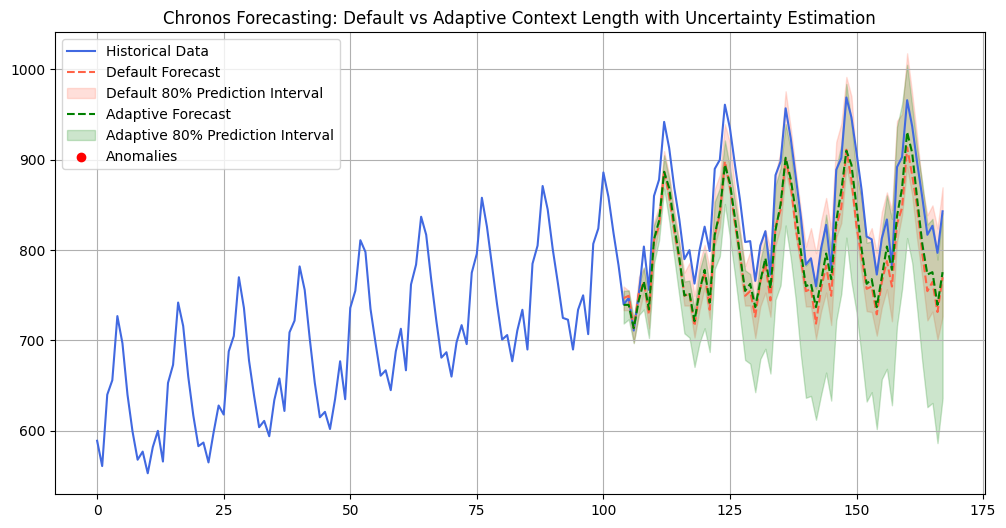

Total number of points are : 64
Number of anomalies detected std: 0, %0.0
Number of anomalies detected ci: 10, %15.625


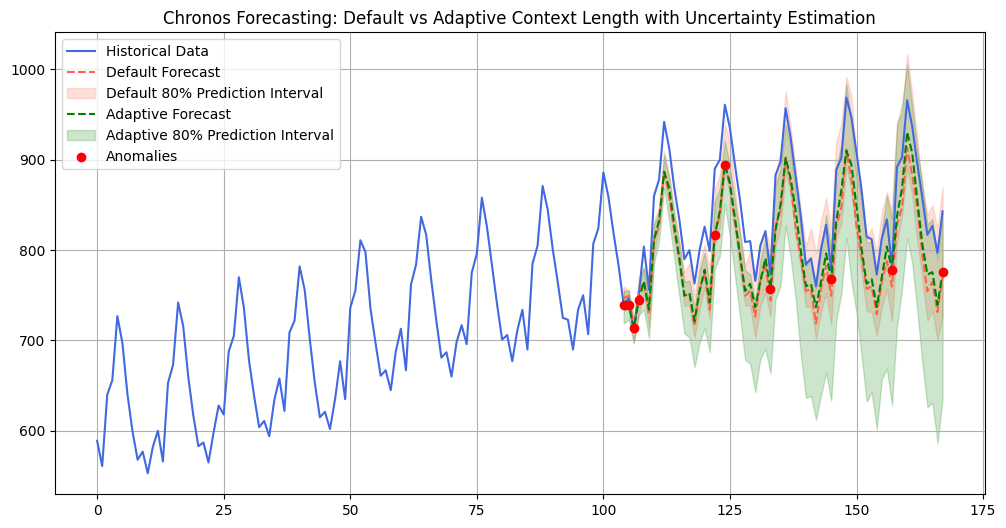

In [ ]:
# @title chronos-t5-small {"vertical-output":true,"display-mode":"form"}
import pandas as pd
import torch
from chronos import BaseChronosPipeline, ChronosPipeline, ChronosBoltPipeline
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import acf, pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy import stats


#  Define Forecast Horizon
PREDICTION_HORIZON = 64
confidence = 0.85

# #  Feature 1: Dynamically determines the best context length based on autocorrelation
def find_optimal_context_length(time_series, max_lag=48):
    acf_values = acf(time_series, nlags=max_lag)
    seasonality = np.argmax(acf_values > 0.5)  # Find highest correlation lag
    if seasonality == 0:
        seasonality = max_lag  # Default to max lag if no seasonality is found
    optimal_length = min(len(time_series), seasonality * 2)  # Use 2 full cycles
    print(f"Selected optimal context length: {optimal_length}")
    return optimal_length



def find_optimal_context_length_pacf(time_series, max_lag=48):
    # Calculate Partial Autocorrelation values
    pacf_values = pacf(time_series, nlags=max_lag)

    # Print the first 10 PACF values for analysis
    print("First 10 PACF Values:", pacf_values[:10])

    # Set a threshold for significant correlation
    threshold = 0.2  # This can be adjusted based on your data

    # Find the lag with the highest PACF value above the threshold (excluding lag 0)
    significant_lags = np.where(np.abs(pacf_values) > threshold)[0]

    if len(significant_lags) == 0:
        # Fallback to max lag if no significant lag is found
        optimal_length = max_lag
    else:
        # Use the highest significant lag to define context length
        optimal_length = min(len(time_series), significant_lags[-1] * 2)

    print(f"Selected optimal context length using PACF: {optimal_length}")
    return optimal_length



#  Load the Chronos model
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",  # Use "amazon/chronos-bolt-small" for Bolt model
    device_map="cuda",  # Change to "cuda" if using GPU
    torch_dtype=torch.bfloat16,
)

df = pd.read_csv(
    "https://raw.githubusercontent.com/plotly/datasets/refs/heads/master/monthly-milk-production-pounds.csv",
    parse_dates=["Month"]
)
df.rename(columns={"Monthly milk production (pounds per cow)": "Production"}, inplace=True)
df = df.sort_values("Month")

# 🔹 Define Training Data & Actual Future Values
train_data = df["Production"].values[:-PREDICTION_HORIZON]  # Use everything except last 24 months
actual_values = df["Production"].values[-PREDICTION_HORIZON:]  # Keep last 24 months for comparison




# --------------------------------------------------------------------------------------------
#  Default Forecast (Fixed Context Length - Uses Entire History)
# --------------------------------------------------------------------------------------------
context_default = torch.tensor(train_data, dtype=torch.float32)
quantiles_default, mean_default = pipeline.predict_quantiles(
    context=context_default,
    prediction_length=PREDICTION_HORIZON,
    quantile_levels=[0.1, 0.5, 0.9],  # 10th (low), 50th (median), 90th (high)
)
forecast_default = pipeline.predict(context=context_default, prediction_length=PREDICTION_HORIZON)
forecast_default_np = forecast_default.numpy().flatten()  # Convert tensor to NumPy for analysis

# --------------------------------------------------------------------------------------------
#  Adaptive Forecast (Uses Feature 1 to Determine Best Context Length)
# --------------------------------------------------------------------------------------------
context_length = find_optimal_context_length(train_data)  # Compute optimal length
context_adaptive = torch.tensor(train_data[-context_length:], dtype=torch.float32)
quantiles_adaptive, mean_adaptive = pipeline.predict_quantiles(
    context=context_adaptive,
    prediction_length=PREDICTION_HORIZON,
    quantile_levels=[0.1, 0.5, 0.9],
)
forecast_adaptive = pipeline.predict(context=context_adaptive, prediction_length=PREDICTION_HORIZON)
forecast_adaptive_np = forecast_adaptive.numpy().flatten()  # Convert tensor to NumPy for analysis





print(f"Forecast Default Shape: {forecast_default_np.shape}")  # Debugging
print(f"Forecast Adaptive Shape: {forecast_adaptive_np.shape}")  # Debugging
# Fix forecast shape if it is incorrectly flattened
if len(forecast_default_np.shape) == 1:
    forecast_default_np = forecast_default_np.reshape(-1, PREDICTION_HORIZON)
if len(forecast_adaptive_np.shape) == 1:
    forecast_adaptive_np = forecast_adaptive_np.reshape(-1, PREDICTION_HORIZON)

# Take the median across samples (axis=0)
forecast_default_np = np.median(forecast_default_np, axis=0)
forecast_adaptive_np = np.median(forecast_adaptive_np, axis=0)

# Double-check that forecast now matches actual values
print(f"Fixed Forecast Default Shape: {forecast_default_np.shape}")  # Should be (24,)
print(f"Fixed Forecast Adaptive Shape: {forecast_adaptive_np.shape}")  # Should be (24,)
print(f"Actual Values Shape: {actual_values.shape}")  # Should be (24,)

# --------------------------------------------------------------------------------------------
#  Compare Forecast Accuracy using MAE & RMSE
# --------------------------------------------------------------------------------------------
mae_default = mean_absolute_error(actual_values, forecast_default_np)
rmse_default = np.sqrt(mean_squared_error(actual_values, forecast_default_np))

mae_adaptive = mean_absolute_error(actual_values, forecast_adaptive_np)
rmse_adaptive = np.sqrt(mean_squared_error(actual_values, forecast_adaptive_np))

print("\n **Forecast Accuracy Comparison**")
print(f" Default Forecast  → MAE: {mae_default:.2f}, RMSE: {rmse_default:.2f}")
print(f" Adaptive Forecast → MAE: {mae_adaptive:.2f}, RMSE: {rmse_adaptive:.2f}")

print("\n Improvement with Adaptive Context Length:")
print(f"   MAE Improvement: {mae_default - mae_adaptive:.2f}")
print(f"   RMSE Improvement: {rmse_default - rmse_adaptive:.2f}")


# Extract Prediction Intervals
low_default, median_default, high_default = quantiles_default[0, :, 0], quantiles_default[0, :, 1], quantiles_default[0, :, 2]
low_adaptive, median_adaptive, high_adaptive = quantiles_adaptive[0, :, 0], quantiles_adaptive[0, :, 1], quantiles_adaptive[0, :, 2]
# Ensure all values are NumPy arrays before comparison
low_default_np = low_default.numpy()
high_default_np = high_default.numpy()
low_adaptive_np = low_adaptive.numpy()
high_adaptive_np = high_adaptive.numpy()

# Check how often actual values fall within predicted uncertainty bounds
coverage_default = np.mean((actual_values >= low_default_np) & (actual_values <= high_default_np))
coverage_adaptive = np.mean((actual_values >= low_adaptive_np) & (actual_values <= high_adaptive_np))

print("\n **Forecast Accuracy Comparison (Including Uncertainty)**")
print(f" Default Forecast  → MAE: {mae_default:.2f}, RMSE: {rmse_default:.2f}, Coverage: {coverage_default:.2%}")
print(f" Adaptive Forecast → MAE: {mae_adaptive:.2f}, RMSE: {rmse_adaptive:.2f}, Coverage: {coverage_adaptive:.2%}")

# --------------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------------
# feature2 Detects anomalies where forecast errors exceed 'threshold' standard deviations.

def detect_anomalies(actual, forecast, threshold=2.5):
    """
    Detects anomalies where forecast errors exceed 'threshold' standard deviations.
    """
    errors = np.abs(actual - forecast)
    mean_error = np.mean(errors)
    std_error = np.std(errors)

    anomalies = (errors > mean_error + threshold * std_error)  # Boolean mask
    return anomalies

# Detect anomalies
anomaly_mask = detect_anomalies(actual_values, forecast_adaptive_np)

# --------------------------------------------------------------------------------------------
#  Plot Forecast Comparison
# --------------------------------------------------------------------------------------------
forecast_index = range(len(df) - PREDICTION_HORIZON, len(df))

plt.figure(figsize=(12, 6))
plt.plot(df["Production"], color="royalblue", label="Historical Data")

# Default Forecast
plt.plot(forecast_index, forecast_default_np, color="tomato", linestyle="dashed", label="Default Forecast")
plt.fill_between(forecast_index, low_default, high_default, color="tomato", alpha=0.2, label="Default 80% Prediction Interval")

# Adaptive Forecast
plt.plot(forecast_index, forecast_adaptive_np, color="green", linestyle="dashed", label="Adaptive Forecast")
plt.fill_between(forecast_index, low_adaptive, high_adaptive, color="green", alpha=0.2, label="Adaptive 80% Prediction Interval")

plt.scatter(
    np.array(forecast_index)[anomaly_mask],
    forecast_adaptive_np[anomaly_mask],
    color="red",
    label="Anomalies",
    zorder=3
)
plt.legend()
plt.grid()
plt.title("Chronos Forecasting: Default vs Adaptive Context Length with Uncertainty Estimation")
plt.show()



def detect_anomalies_ci(actual, forecast, confidence=confidence):
    errors = np.abs(actual - forecast)
    mean_error = np.mean(errors)
    std_error = np.std(errors)  # Use standard deviation directly

    margin = stats.t.ppf((1 + confidence) / 2.0, df=len(errors) - 1) * std_error  # Correct margin calculation
    lower_bound = mean_error - margin
    upper_bound = mean_error + margin

    anomalies = (errors < lower_bound) | (errors > upper_bound)
    return anomalies, lower_bound, upper_bound



anomaly_mask_ci, low_ci, high_ci = detect_anomalies_ci(actual_values, forecast_adaptive_np)

total_points = len(forecast_adaptive_np)

print(f"Total number of points are : {total_points}")

num_anomalies = np.sum(anomaly_mask)
print(f"Number of anomalies detected std: {num_anomalies}, %{num_anomalies/total_points}")

num_anomalies = np.sum(anomaly_mask_ci)
print(f"Number of anomalies detected ci: {num_anomalies}, %{(num_anomalies/total_points)*100}")


forecast_index = range(len(df) - PREDICTION_HORIZON, len(df))

plt.figure(figsize=(12, 6))
plt.plot(df["Production"], color="royalblue", label="Historical Data")

# Default Forecast
plt.plot(forecast_index, forecast_default_np, color="tomato", linestyle="dashed", label="Default Forecast")
plt.fill_between(forecast_index, low_default, high_default, color="tomato", alpha=0.2, label="Default 80% Prediction Interval")

# Adaptive Forecast
plt.plot(forecast_index, forecast_adaptive_np, color="green", linestyle="dashed", label="Adaptive Forecast")
plt.fill_between(forecast_index, low_adaptive, high_adaptive, color="green", alpha=0.2, label="Adaptive 80% Prediction Interval")


plt.scatter(
    np.array(forecast_index)[anomaly_mask_ci],
    forecast_adaptive_np[anomaly_mask_ci],
    color="red",
    label="Anomalies",
    zorder=3
)

plt.legend()
plt.grid()
plt.title("Chronos Forecasting: Default vs Adaptive Context Length with Uncertainty Estimation")
plt.show()





#===================================================================================
#===================================================================================
#===================================================================================
#===================================================================================
# forecast = pipeline.predict(context=context, prediction_length=24)
# print("Forecasted Values:\n", forecast.numpy())

# Print available model documentation
# print(ChronosPipeline.predict.__doc__)  # for Chronos models
# print(ChronosBoltPipeline.predict.__doc__)  # for Chronos-Bolt models

# # Plot the forecast
# forecast_index = range(len(df), len(df) + 24)
# low, median, high = quantiles[0, :, 1], quantiles[0, :, 2], quantiles[0, :, 3]

# plt.figure(figsize=(10, 5))
# plt.plot(df["Production"], color="royalblue", label="historical data")
# plt.plot(forecast_index, median, color="tomato", label="median forecast")
# plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="90% prediction interval")
# plt.legend()
# plt.grid()
# plt.show()

# # Extracting encoder embeddings
# embeddings, tokenizer_state = pipeline.embed(context)
# print("Extracted Embeddings:", embeddings.shape)
#===================================================================================




config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/806M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

Selected optimal context length: 96
Forecast Default Shape: (1280,)
Forecast Adaptive Shape: (1280,)
Fixed Forecast Default Shape: (64,)
Fixed Forecast Adaptive Shape: (64,)
Actual Values Shape: (64,)

 **Forecast Accuracy Comparison**
 Default Forecast  → MAE: 21.60, RMSE: 27.18
 Adaptive Forecast → MAE: 17.43, RMSE: 21.51

 Improvement with Adaptive Context Length:
   MAE Improvement: 4.17
   RMSE Improvement: 5.68

 **Forecast Accuracy Comparison (Including Uncertainty)**
 Default Forecast  → MAE: 21.60, RMSE: 27.18, Coverage: 64.06%
 Adaptive Forecast → MAE: 17.43, RMSE: 21.51, Coverage: 59.38%


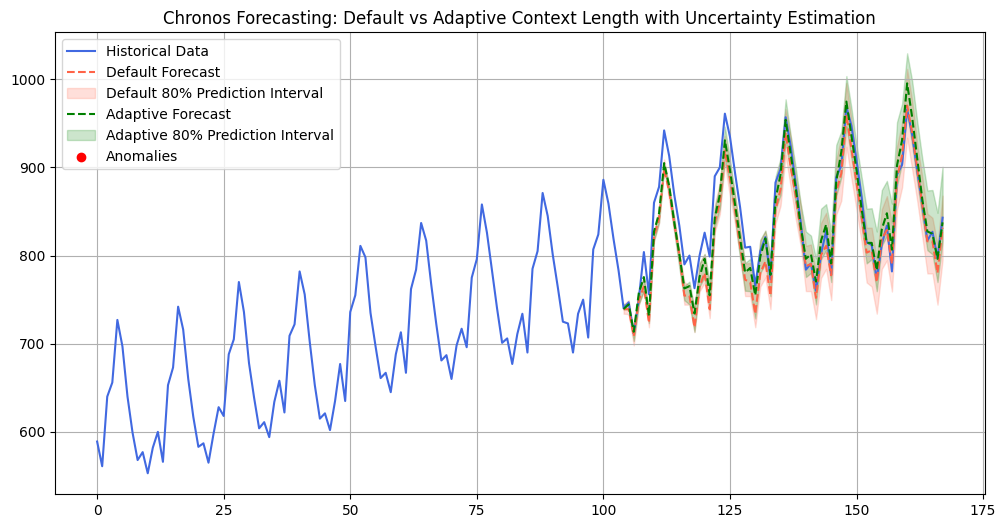

Total number of points are : 64
Number of anomalies detected std: 0, %0.0
Number of anomalies detected ci: 4, %6.25


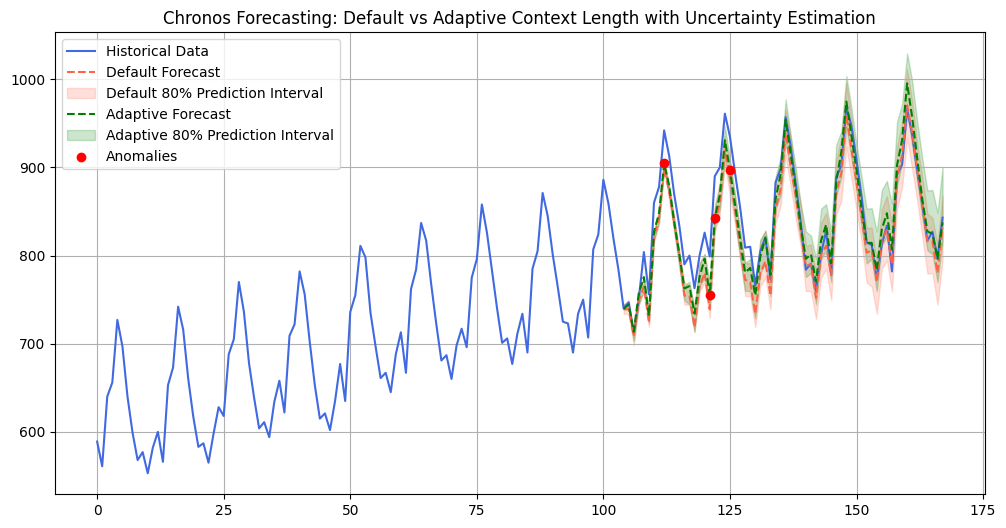

In [ ]:
# @title chronos-t5-base {"vertical-output":true,"display-mode":"form"}
import pandas as pd
import torch
from chronos import BaseChronosPipeline, ChronosPipeline, ChronosBoltPipeline
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import acf, pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy import stats

#  Define Forecast Horizon
PREDICTION_HORIZON = 64

# #  Feature 1: Dynamically determines the best context length based on autocorrelation
def find_optimal_context_length(time_series, max_lag=48):
    acf_values = acf(time_series, nlags=max_lag)
    seasonality = np.argmax(acf_values > 0.5)  # Find highest correlation lag
    if seasonality == 0:
        seasonality = max_lag  # Default to max lag if no seasonality is found
    optimal_length = min(len(time_series), seasonality * 2)  # Use 2 full cycles
    print(f"Selected optimal context length: {optimal_length}")
    return optimal_length



def find_optimal_context_length_pacf(time_series, max_lag=48):
    # Calculate Partial Autocorrelation values
    pacf_values = pacf(time_series, nlags=max_lag)

    # Print the first 10 PACF values for analysis
    print("First 10 PACF Values:", pacf_values[:10])

    # Set a threshold for significant correlation
    threshold = 0.2  # This can be adjusted based on your data

    # Find the lag with the highest PACF value above the threshold (excluding lag 0)
    significant_lags = np.where(np.abs(pacf_values) > threshold)[0]

    if len(significant_lags) == 0:
        # Fallback to max lag if no significant lag is found
        optimal_length = max_lag
    else:
        # Use the highest significant lag to define context length
        optimal_length = min(len(time_series), significant_lags[-1] * 2)

    print(f"Selected optimal context length using PACF: {optimal_length}")
    return optimal_length



#  Load the Chronos model
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-base",  # Use "amazon/chronos-bolt-small" for Bolt model
    device_map="cuda",  # Change to "cuda" if using GPU
    torch_dtype=torch.bfloat16,
)

df = pd.read_csv(
    "https://raw.githubusercontent.com/plotly/datasets/refs/heads/master/monthly-milk-production-pounds.csv",
    parse_dates=["Month"]
)
df.rename(columns={"Monthly milk production (pounds per cow)": "Production"}, inplace=True)
df = df.sort_values("Month")

# 🔹 Define Training Data & Actual Future Values
train_data = df["Production"].values[:-PREDICTION_HORIZON]  # Use everything except last 24 months
actual_values = df["Production"].values[-PREDICTION_HORIZON:]  # Keep last 24 months for comparison




# --------------------------------------------------------------------------------------------
#  Default Forecast (Fixed Context Length - Uses Entire History)
# --------------------------------------------------------------------------------------------
context_default = torch.tensor(train_data, dtype=torch.float32)
quantiles_default, mean_default = pipeline.predict_quantiles(
    context=context_default,
    prediction_length=PREDICTION_HORIZON,
    quantile_levels=[0.1, 0.5, 0.9],  # 10th (low), 50th (median), 90th (high)
)
forecast_default = pipeline.predict(context=context_default, prediction_length=PREDICTION_HORIZON)
forecast_default_np = forecast_default.numpy().flatten()  # Convert tensor to NumPy for analysis

# --------------------------------------------------------------------------------------------
#  Adaptive Forecast (Uses Feature 1 to Determine Best Context Length)
# --------------------------------------------------------------------------------------------
context_length = find_optimal_context_length(train_data)  # Compute optimal length
context_adaptive = torch.tensor(train_data[-context_length:], dtype=torch.float32)
quantiles_adaptive, mean_adaptive = pipeline.predict_quantiles(
    context=context_adaptive,
    prediction_length=PREDICTION_HORIZON,
    quantile_levels=[0.1, 0.5, 0.9],
)
forecast_adaptive = pipeline.predict(context=context_adaptive, prediction_length=PREDICTION_HORIZON)
forecast_adaptive_np = forecast_adaptive.numpy().flatten()  # Convert tensor to NumPy for analysis





print(f"Forecast Default Shape: {forecast_default_np.shape}")  # Debugging
print(f"Forecast Adaptive Shape: {forecast_adaptive_np.shape}")  # Debugging
# Fix forecast shape if it is incorrectly flattened
if len(forecast_default_np.shape) == 1:
    forecast_default_np = forecast_default_np.reshape(-1, PREDICTION_HORIZON)
if len(forecast_adaptive_np.shape) == 1:
    forecast_adaptive_np = forecast_adaptive_np.reshape(-1, PREDICTION_HORIZON)

# Take the median across samples (axis=0)
forecast_default_np = np.median(forecast_default_np, axis=0)
forecast_adaptive_np = np.median(forecast_adaptive_np, axis=0)

# Double-check that forecast now matches actual values
print(f"Fixed Forecast Default Shape: {forecast_default_np.shape}")  # Should be (24,)
print(f"Fixed Forecast Adaptive Shape: {forecast_adaptive_np.shape}")  # Should be (24,)
print(f"Actual Values Shape: {actual_values.shape}")  # Should be (24,)

# --------------------------------------------------------------------------------------------
#  Compare Forecast Accuracy using MAE & RMSE
# --------------------------------------------------------------------------------------------
mae_default = mean_absolute_error(actual_values, forecast_default_np)
rmse_default = np.sqrt(mean_squared_error(actual_values, forecast_default_np))

mae_adaptive = mean_absolute_error(actual_values, forecast_adaptive_np)
rmse_adaptive = np.sqrt(mean_squared_error(actual_values, forecast_adaptive_np))

print("\n **Forecast Accuracy Comparison**")
print(f" Default Forecast  → MAE: {mae_default:.2f}, RMSE: {rmse_default:.2f}")
print(f" Adaptive Forecast → MAE: {mae_adaptive:.2f}, RMSE: {rmse_adaptive:.2f}")

print("\n Improvement with Adaptive Context Length:")
print(f"   MAE Improvement: {mae_default - mae_adaptive:.2f}")
print(f"   RMSE Improvement: {rmse_default - rmse_adaptive:.2f}")


# Extract Prediction Intervals
low_default, median_default, high_default = quantiles_default[0, :, 0], quantiles_default[0, :, 1], quantiles_default[0, :, 2]
low_adaptive, median_adaptive, high_adaptive = quantiles_adaptive[0, :, 0], quantiles_adaptive[0, :, 1], quantiles_adaptive[0, :, 2]
# Ensure all values are NumPy arrays before comparison
low_default_np = low_default.numpy()
high_default_np = high_default.numpy()
low_adaptive_np = low_adaptive.numpy()
high_adaptive_np = high_adaptive.numpy()

# Check how often actual values fall within predicted uncertainty bounds
coverage_default = np.mean((actual_values >= low_default_np) & (actual_values <= high_default_np))
coverage_adaptive = np.mean((actual_values >= low_adaptive_np) & (actual_values <= high_adaptive_np))

print("\n **Forecast Accuracy Comparison (Including Uncertainty)**")
print(f" Default Forecast  → MAE: {mae_default:.2f}, RMSE: {rmse_default:.2f}, Coverage: {coverage_default:.2%}")
print(f" Adaptive Forecast → MAE: {mae_adaptive:.2f}, RMSE: {rmse_adaptive:.2f}, Coverage: {coverage_adaptive:.2%}")

# --------------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------------
# feature2 Detects anomalies where forecast errors exceed 'threshold' standard deviations.

def detect_anomalies(actual, forecast, threshold=2.5):
    """
    Detects anomalies where forecast errors exceed 'threshold' standard deviations.
    """
    errors = np.abs(actual - forecast)
    mean_error = np.mean(errors)
    std_error = np.std(errors)

    anomalies = (errors > mean_error + threshold * std_error)  # Boolean mask
    return anomalies

# Detect anomalies
anomaly_mask = detect_anomalies(actual_values, forecast_adaptive_np)

# --------------------------------------------------------------------------------------------
#  Plot Forecast Comparison
# --------------------------------------------------------------------------------------------
forecast_index = range(len(df) - PREDICTION_HORIZON, len(df))

plt.figure(figsize=(12, 6))
plt.plot(df["Production"], color="royalblue", label="Historical Data")

# Default Forecast
plt.plot(forecast_index, forecast_default_np, color="tomato", linestyle="dashed", label="Default Forecast")
plt.fill_between(forecast_index, low_default, high_default, color="tomato", alpha=0.2, label="Default 80% Prediction Interval")

# Adaptive Forecast
plt.plot(forecast_index, forecast_adaptive_np, color="green", linestyle="dashed", label="Adaptive Forecast")
plt.fill_between(forecast_index, low_adaptive, high_adaptive, color="green", alpha=0.2, label="Adaptive 80% Prediction Interval")

plt.scatter(
    np.array(forecast_index)[anomaly_mask],
    forecast_adaptive_np[anomaly_mask],
    color="red",
    label="Anomalies",
    zorder=3
)
plt.legend()
plt.grid()
plt.title("Chronos Forecasting: Default vs Adaptive Context Length with Uncertainty Estimation")
plt.show()

confidence = 0.85

def detect_anomalies_ci(actual, forecast, confidence=confidence):
    errors = np.abs(actual - forecast)
    mean_error = np.mean(errors)
    std_error = np.std(errors)  # Use standard deviation directly

    margin = stats.t.ppf((1 + confidence) / 2.0, df=len(errors) - 1) * std_error  # Correct margin calculation
    lower_bound = mean_error - margin
    upper_bound = mean_error + margin

    anomalies = (errors < lower_bound) | (errors > upper_bound)
    return anomalies, lower_bound, upper_bound



anomaly_mask_ci, low_ci, high_ci = detect_anomalies_ci(actual_values, forecast_adaptive_np)

total_points = len(forecast_adaptive_np)

print(f"Total number of points are : {total_points}")

num_anomalies = np.sum(anomaly_mask)
print(f"Number of anomalies detected std: {num_anomalies}, %{num_anomalies/total_points}")

num_anomalies = np.sum(anomaly_mask_ci)
print(f"Number of anomalies detected ci: {num_anomalies}, %{(num_anomalies/total_points)*100}")


forecast_index = range(len(df) - PREDICTION_HORIZON, len(df))

plt.figure(figsize=(12, 6))
plt.plot(df["Production"], color="royalblue", label="Historical Data")

# Default Forecast
plt.plot(forecast_index, forecast_default_np, color="tomato", linestyle="dashed", label="Default Forecast")
plt.fill_between(forecast_index, low_default, high_default, color="tomato", alpha=0.2, label="Default 80% Prediction Interval")

# Adaptive Forecast
plt.plot(forecast_index, forecast_adaptive_np, color="green", linestyle="dashed", label="Adaptive Forecast")
plt.fill_between(forecast_index, low_adaptive, high_adaptive, color="green", alpha=0.2, label="Adaptive 80% Prediction Interval")


plt.scatter(
    np.array(forecast_index)[anomaly_mask_ci],
    forecast_adaptive_np[anomaly_mask_ci],
    color="red",
    label="Anomalies",
    zorder=3
)

plt.legend()
plt.grid()
plt.title("Chronos Forecasting: Default vs Adaptive Context Length with Uncertainty Estimation")
plt.show()





#===================================================================================
#===================================================================================
#===================================================================================
#===================================================================================
# forecast = pipeline.predict(context=context, prediction_length=24)
# print("Forecasted Values:\n", forecast.numpy())

# Print available model documentation
# print(ChronosPipeline.predict.__doc__)  # for Chronos models
# print(ChronosBoltPipeline.predict.__doc__)  # for Chronos-Bolt models

# # Plot the forecast
# forecast_index = range(len(df), len(df) + 24)
# low, median, high = quantiles[0, :, 1], quantiles[0, :, 2], quantiles[0, :, 3]

# plt.figure(figsize=(10, 5))
# plt.plot(df["Production"], color="royalblue", label="historical data")
# plt.plot(forecast_index, median, color="tomato", label="median forecast")
# plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="90% prediction interval")
# plt.legend()
# plt.grid()
# plt.show()

# # Extracting encoder embeddings
# embeddings, tokenizer_state = pipeline.embed(context)
# print("Extracted Embeddings:", embeddings.shape)
#===================================================================================




config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.84G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

Selected optimal context length: 96
Forecast Default Shape: (1280,)
Forecast Adaptive Shape: (1280,)
Fixed Forecast Default Shape: (64,)
Fixed Forecast Adaptive Shape: (64,)
Actual Values Shape: (64,)

 **Forecast Accuracy Comparison**
 Default Forecast  → MAE: 45.94, RMSE: 49.09
 Adaptive Forecast → MAE: 44.89, RMSE: 47.67

 Improvement with Adaptive Context Length:
   MAE Improvement: 1.05
   RMSE Improvement: 1.42

 **Forecast Accuracy Comparison (Including Uncertainty)**
 Default Forecast  → MAE: 45.94, RMSE: 49.09, Coverage: 37.50%
 Adaptive Forecast → MAE: 44.89, RMSE: 47.67, Coverage: 42.19%


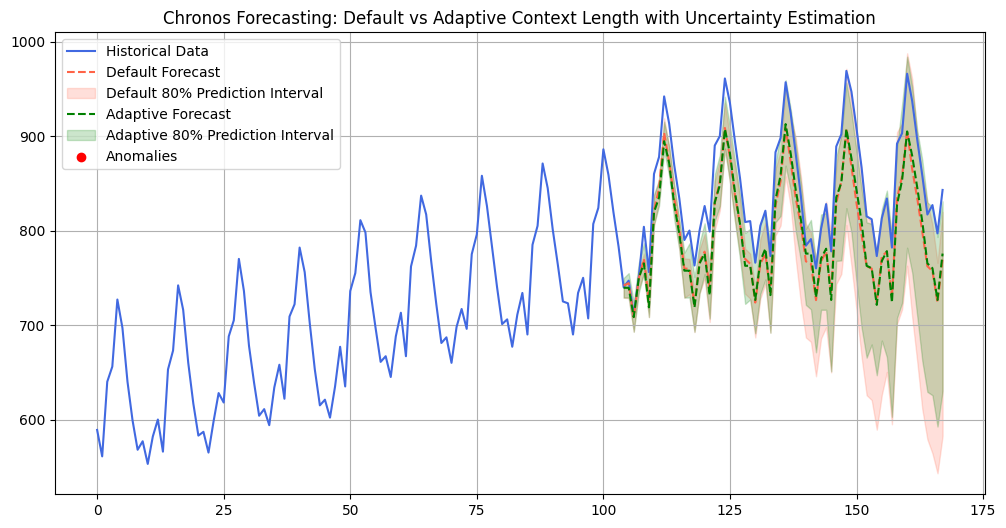

Total number of points are : 64
Number of anomalies detected std: 0, %0.0
Number of anomalies detected ci: 8, %12.5


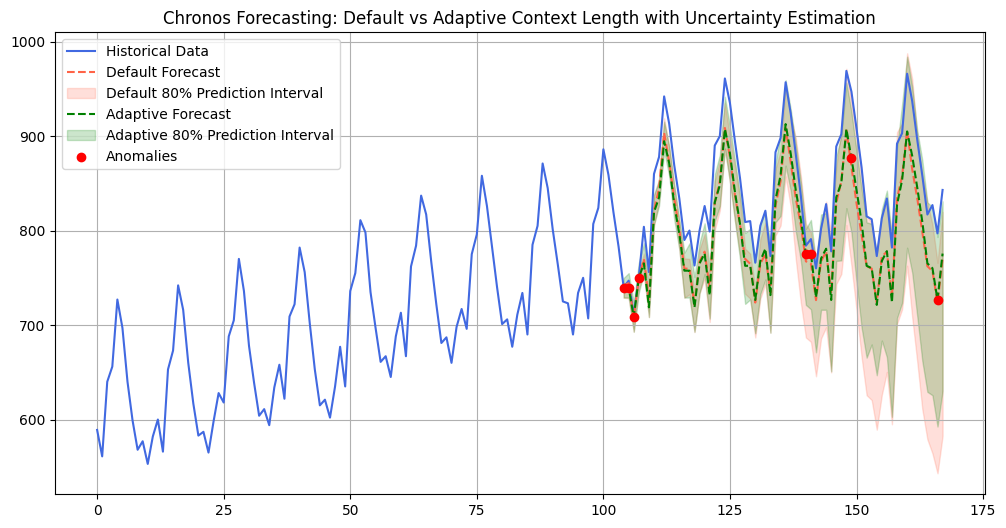

In [ ]:
# @title chronos-t5-large {"vertical-output":true,"display-mode":"form"}
import pandas as pd
import torch
from chronos import BaseChronosPipeline, ChronosPipeline, ChronosBoltPipeline
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import acf, pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy import stats

#  Define Forecast Horizon
PREDICTION_HORIZON = 64

# #  Feature 1: Dynamically determines the best context length based on autocorrelation
def find_optimal_context_length(time_series, max_lag=48):
    acf_values = acf(time_series, nlags=max_lag)
    seasonality = np.argmax(acf_values > 0.5)  # Find highest correlation lag
    if seasonality == 0:
        seasonality = max_lag  # Default to max lag if no seasonality is found
    optimal_length = min(len(time_series), seasonality * 2)  # Use 2 full cycles
    print(f"Selected optimal context length: {optimal_length}")
    return optimal_length



def find_optimal_context_length_pacf(time_series, max_lag=48):
    # Calculate Partial Autocorrelation values
    pacf_values = pacf(time_series, nlags=max_lag)

    # Print the first 10 PACF values for analysis
    print("First 10 PACF Values:", pacf_values[:10])

    # Set a threshold for significant correlation
    threshold = 0.2  # This can be adjusted based on your data

    # Find the lag with the highest PACF value above the threshold (excluding lag 0)
    significant_lags = np.where(np.abs(pacf_values) > threshold)[0]

    if len(significant_lags) == 0:
        # Fallback to max lag if no significant lag is found
        optimal_length = max_lag
    else:
        # Use the highest significant lag to define context length
        optimal_length = min(len(time_series), significant_lags[-1] * 2)

    print(f"Selected optimal context length using PACF: {optimal_length}")
    return optimal_length



#  Load the Chronos model
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large",  # Use "amazon/chronos-bolt-small" for Bolt model
    device_map="cuda",  # Change to "cuda" if using GPU
    torch_dtype=torch.bfloat16,
)

df = pd.read_csv(
    "https://raw.githubusercontent.com/plotly/datasets/refs/heads/master/monthly-milk-production-pounds.csv",
    parse_dates=["Month"]
)
df.rename(columns={"Monthly milk production (pounds per cow)": "Production"}, inplace=True)
df = df.sort_values("Month")

# 🔹 Define Training Data & Actual Future Values
train_data = df["Production"].values[:-PREDICTION_HORIZON]  # Use everything except last 24 months
actual_values = df["Production"].values[-PREDICTION_HORIZON:]  # Keep last 24 months for comparison




# --------------------------------------------------------------------------------------------
#  Default Forecast (Fixed Context Length - Uses Entire History)
# --------------------------------------------------------------------------------------------
context_default = torch.tensor(train_data, dtype=torch.float32)
quantiles_default, mean_default = pipeline.predict_quantiles(
    context=context_default,
    prediction_length=PREDICTION_HORIZON,
    quantile_levels=[0.1, 0.5, 0.9],  # 10th (low), 50th (median), 90th (high)
)
forecast_default = pipeline.predict(context=context_default, prediction_length=PREDICTION_HORIZON)
forecast_default_np = forecast_default.numpy().flatten()  # Convert tensor to NumPy for analysis

# --------------------------------------------------------------------------------------------
#  Adaptive Forecast (Uses Feature 1 to Determine Best Context Length)
# --------------------------------------------------------------------------------------------
context_length = find_optimal_context_length(train_data)  # Compute optimal length
context_adaptive = torch.tensor(train_data[-context_length:], dtype=torch.float32)
quantiles_adaptive, mean_adaptive = pipeline.predict_quantiles(
    context=context_adaptive,
    prediction_length=PREDICTION_HORIZON,
    quantile_levels=[0.1, 0.5, 0.9],
)
forecast_adaptive = pipeline.predict(context=context_adaptive, prediction_length=PREDICTION_HORIZON)
forecast_adaptive_np = forecast_adaptive.numpy().flatten()  # Convert tensor to NumPy for analysis





print(f"Forecast Default Shape: {forecast_default_np.shape}")  # Debugging
print(f"Forecast Adaptive Shape: {forecast_adaptive_np.shape}")  # Debugging
# Fix forecast shape if it is incorrectly flattened
if len(forecast_default_np.shape) == 1:
    forecast_default_np = forecast_default_np.reshape(-1, PREDICTION_HORIZON)
if len(forecast_adaptive_np.shape) == 1:
    forecast_adaptive_np = forecast_adaptive_np.reshape(-1, PREDICTION_HORIZON)

# Take the median across samples (axis=0)
forecast_default_np = np.median(forecast_default_np, axis=0)
forecast_adaptive_np = np.median(forecast_adaptive_np, axis=0)

# Double-check that forecast now matches actual values
print(f"Fixed Forecast Default Shape: {forecast_default_np.shape}")  # Should be (24,)
print(f"Fixed Forecast Adaptive Shape: {forecast_adaptive_np.shape}")  # Should be (24,)
print(f"Actual Values Shape: {actual_values.shape}")  # Should be (24,)

# --------------------------------------------------------------------------------------------
#  Compare Forecast Accuracy using MAE & RMSE
# --------------------------------------------------------------------------------------------
mae_default = mean_absolute_error(actual_values, forecast_default_np)
rmse_default = np.sqrt(mean_squared_error(actual_values, forecast_default_np))

mae_adaptive = mean_absolute_error(actual_values, forecast_adaptive_np)
rmse_adaptive = np.sqrt(mean_squared_error(actual_values, forecast_adaptive_np))

print("\n **Forecast Accuracy Comparison**")
print(f" Default Forecast  → MAE: {mae_default:.2f}, RMSE: {rmse_default:.2f}")
print(f" Adaptive Forecast → MAE: {mae_adaptive:.2f}, RMSE: {rmse_adaptive:.2f}")

print("\n Improvement with Adaptive Context Length:")
print(f"   MAE Improvement: {mae_default - mae_adaptive:.2f}")
print(f"   RMSE Improvement: {rmse_default - rmse_adaptive:.2f}")


# Extract Prediction Intervals
low_default, median_default, high_default = quantiles_default[0, :, 0], quantiles_default[0, :, 1], quantiles_default[0, :, 2]
low_adaptive, median_adaptive, high_adaptive = quantiles_adaptive[0, :, 0], quantiles_adaptive[0, :, 1], quantiles_adaptive[0, :, 2]
# Ensure all values are NumPy arrays before comparison
low_default_np = low_default.numpy()
high_default_np = high_default.numpy()
low_adaptive_np = low_adaptive.numpy()
high_adaptive_np = high_adaptive.numpy()

# Check how often actual values fall within predicted uncertainty bounds
coverage_default = np.mean((actual_values >= low_default_np) & (actual_values <= high_default_np))
coverage_adaptive = np.mean((actual_values >= low_adaptive_np) & (actual_values <= high_adaptive_np))

print("\n **Forecast Accuracy Comparison (Including Uncertainty)**")
print(f" Default Forecast  → MAE: {mae_default:.2f}, RMSE: {rmse_default:.2f}, Coverage: {coverage_default:.2%}")
print(f" Adaptive Forecast → MAE: {mae_adaptive:.2f}, RMSE: {rmse_adaptive:.2f}, Coverage: {coverage_adaptive:.2%}")

# --------------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------------
# feature2 Detects anomalies where forecast errors exceed 'threshold' standard deviations.

def detect_anomalies(actual, forecast, threshold=2.5):
    """
    Detects anomalies where forecast errors exceed 'threshold' standard deviations.
    """
    errors = np.abs(actual - forecast)
    mean_error = np.mean(errors)
    std_error = np.std(errors)

    anomalies = (errors > mean_error + threshold * std_error)  # Boolean mask
    return anomalies

# Detect anomalies
anomaly_mask = detect_anomalies(actual_values, forecast_adaptive_np)

# --------------------------------------------------------------------------------------------
#  Plot Forecast Comparison
# --------------------------------------------------------------------------------------------
forecast_index = range(len(df) - PREDICTION_HORIZON, len(df))

plt.figure(figsize=(12, 6))
plt.plot(df["Production"], color="royalblue", label="Historical Data")

# Default Forecast
plt.plot(forecast_index, forecast_default_np, color="tomato", linestyle="dashed", label="Default Forecast")
plt.fill_between(forecast_index, low_default, high_default, color="tomato", alpha=0.2, label="Default 80% Prediction Interval")

# Adaptive Forecast
plt.plot(forecast_index, forecast_adaptive_np, color="green", linestyle="dashed", label="Adaptive Forecast")
plt.fill_between(forecast_index, low_adaptive, high_adaptive, color="green", alpha=0.2, label="Adaptive 80% Prediction Interval")

plt.scatter(
    np.array(forecast_index)[anomaly_mask],
    forecast_adaptive_np[anomaly_mask],
    color="red",
    label="Anomalies",
    zorder=3
)
plt.legend()
plt.grid()
plt.title("Chronos Forecasting: Default vs Adaptive Context Length with Uncertainty Estimation")
plt.show()

confidence = 0.85

def detect_anomalies_ci(actual, forecast, confidence=confidence):
    errors = np.abs(actual - forecast)
    mean_error = np.mean(errors)
    std_error = np.std(errors)  # Use standard deviation directly

    margin = stats.t.ppf((1 + confidence) / 2.0, df=len(errors) - 1) * std_error  # Correct margin calculation
    lower_bound = mean_error - margin
    upper_bound = mean_error + margin

    anomalies = (errors < lower_bound) | (errors > upper_bound)
    return anomalies, lower_bound, upper_bound



anomaly_mask_ci, low_ci, high_ci = detect_anomalies_ci(actual_values, forecast_adaptive_np)

total_points = len(forecast_adaptive_np)

print(f"Total number of points are : {total_points}")

num_anomalies = np.sum(anomaly_mask)
print(f"Number of anomalies detected std: {num_anomalies}, %{num_anomalies/total_points}")

num_anomalies = np.sum(anomaly_mask_ci)
print(f"Number of anomalies detected ci: {num_anomalies}, %{(num_anomalies/total_points)*100}")


forecast_index = range(len(df) - PREDICTION_HORIZON, len(df))

plt.figure(figsize=(12, 6))
plt.plot(df["Production"], color="royalblue", label="Historical Data")

# Default Forecast
plt.plot(forecast_index, forecast_default_np, color="tomato", linestyle="dashed", label="Default Forecast")
plt.fill_between(forecast_index, low_default, high_default, color="tomato", alpha=0.2, label="Default 80% Prediction Interval")

# Adaptive Forecast
plt.plot(forecast_index, forecast_adaptive_np, color="green", linestyle="dashed", label="Adaptive Forecast")
plt.fill_between(forecast_index, low_adaptive, high_adaptive, color="green", alpha=0.2, label="Adaptive 80% Prediction Interval")


plt.scatter(
    np.array(forecast_index)[anomaly_mask_ci],
    forecast_adaptive_np[anomaly_mask_ci],
    color="red",
    label="Anomalies",
    zorder=3
)

plt.legend()
plt.grid()
plt.title("Chronos Forecasting: Default vs Adaptive Context Length with Uncertainty Estimation")
plt.show()





#===================================================================================
#===================================================================================
#===================================================================================
#===================================================================================
# forecast = pipeline.predict(context=context, prediction_length=24)
# print("Forecasted Values:\n", forecast.numpy())

# Print available model documentation
# print(ChronosPipeline.predict.__doc__)  # for Chronos models
# print(ChronosBoltPipeline.predict.__doc__)  # for Chronos-Bolt models

# # Plot the forecast
# forecast_index = range(len(df), len(df) + 24)
# low, median, high = quantiles[0, :, 1], quantiles[0, :, 2], quantiles[0, :, 3]

# plt.figure(figsize=(10, 5))
# plt.plot(df["Production"], color="royalblue", label="historical data")
# plt.plot(forecast_index, median, color="tomato", label="median forecast")
# plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="90% prediction interval")
# plt.legend()
# plt.grid()
# plt.show()

# # Extracting encoder embeddings
# embeddings, tokenizer_state = pipeline.embed(context)
# print("Extracted Embeddings:", embeddings.shape)
#===================================================================================


